In [2]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

# DATA PREPROCESSING

We are going to do time series analysis and forecasting for furniture sales.

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/charcode123/SUPERSTORE-SALES-PREDICTION/main/DATA/pred.csv")


In [4]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [5]:
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%m/%d/%Y')
furniture = df.loc[df['Category'] == 'Furniture']

We have a good 4-year furniture sales data. 

In [6]:
furniture['Order Date'].min()

Timestamp('2014-01-06 00:00:00')

In [7]:
furniture['Order Date'].max()

Timestamp('2017-12-30 00:00:00')

## Data preprocessing

This step includes removing columns we do not need, check missing values, aggregate sales by date and so on.

In [8]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')

In [9]:
furniture.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [10]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()

In [11]:
furniture.head()

,Order Date,Sales
0,2014-01-06,2573.820
1,2014-01-07,76.728
2,2014-01-10,51.940
3,2014-01-11,9.940
4,2014-01-13,879.939


## Indexing with time series data

In [12]:
furniture = furniture.set_index('Order Date')
furniture.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

Our current datetime data can be tricky to work with, therefore, we will use the averages daily sales value for that month instead, and we are using the start of each month as the timestamp.

In [13]:
y = furniture['Sales'].resample('MS').mean()

Have a quick peek 2017 sales data.

In [14]:
y['2017':]

Order Date
2017-01-01     397.602133
2017-02-01     528.179800
2017-03-01     544.672240
2017-04-01     453.297905
2017-05-01     678.302328
2017-06-01     826.460291
2017-07-01     562.524857
2017-08-01     857.881889
2017-09-01    1209.508583
2017-10-01     875.362728
2017-11-01    1277.817759
2017-12-01    1256.298672
Freq: MS, Name: Sales, dtype: float64

## Visualizing furniture sales time series data

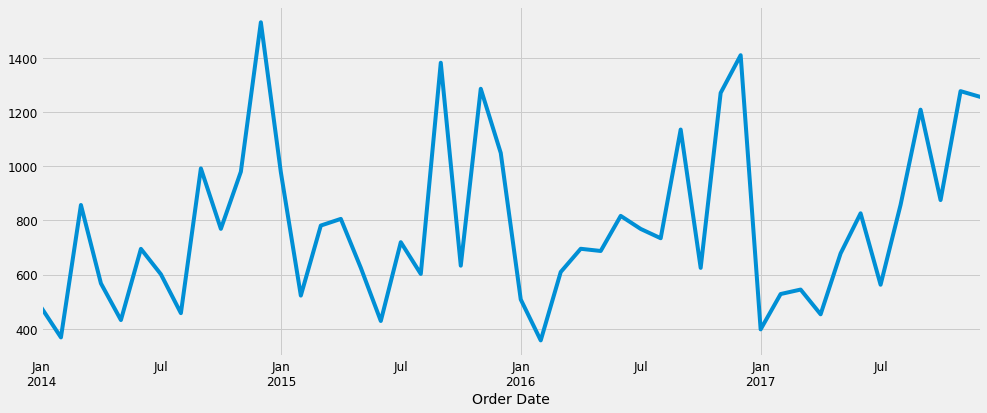

In [15]:
y.plot(figsize=(15, 6))
plt.show()

Some distinguishable patterns appear when we plot the data. The time-series has seasonality pattern, such as sales are always low at the beginning of the year and high at the end of the year. There is always a strong upward trend within any single year with a couple of low months in the mid of the year.

We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

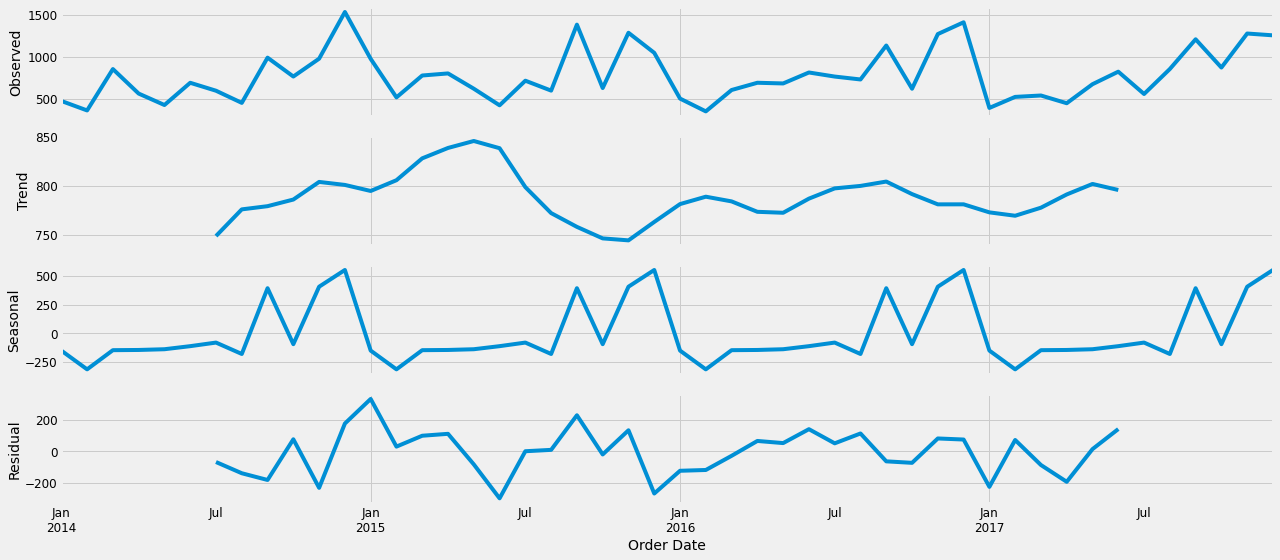

In [16]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

The plot above clearly shows that the sales of furniture is unstable, along with its obvious seasonality.

#Time series forescasting with linear regression
we are going to apply linear regression first before moving on to more advance models

## Getting the data ready

In [68]:
F1= df.loc[df['Category'] == 'Furniture']

In [69]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
F1.drop(cols, axis=1, inplace=True)
F1= F1.sort_values('Order Date')

In [70]:
F1.head()

,Order Date,Sales
7474,2014-01-06,2573.820
7660,2014-01-07,76.728
866,2014-01-10,51.940
716,2014-01-11,9.940
2978,2014-01-13,545.940


In [71]:
len(F1)

2121

In [96]:
f1=[]
f1=F1['Sales']

In [97]:
f1=list(f1)
f2=f1.copy()


In [98]:
print(len(f1),len(f2))

2121 2121


In [99]:
f2.pop(0)


2573.82

In [100]:
len(f2)

2120

In [101]:
len(f1)

2121

In [102]:
f1.pop(2120)

323.136

In [103]:
F=pd.DataFrame()
F['Sales']=f1
F['F-Sales']=f2

In [104]:
F.head()

,Sales,F-Sales
0,2573.820,76.728
1,76.728,51.940
2,51.940,9.940
3,9.940,545.940
4,545.940,333.999


In [105]:
F['index']=F.index

In [127]:
F.tail()

,Sales,F-Sales,index
2115,68.46,258.750,2115
2116,258.75,1207.840,2116
2117,1207.84,101.120,2117
2118,101.12,300.980,2118
2119,300.98,323.136,2119


In [107]:
Y=F.drop(['Sales','index'],axis=1,inplace=False)

In [108]:
Y.head()

,F-Sales
0,76.728
1,51.940
2,9.940
3,545.940
4,333.999


In [113]:
X=F.drop(['F-Sales'],axis=1 ,inplace=False )

In [114]:
X.head()

,Sales,index
0,2573.820,0
1,76.728,1
2,51.940,2
3,9.940,3
4,545.940,4


## model1 linear regression

In [138]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

In [121]:
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.2)

In [122]:
from sklearn.linear_model import LinearRegression

In [123]:
model1=LinearRegression()

In [124]:
model1=sm.OLS(y_train,X_train).fit()

In [125]:
print(model1.summary())

                                 OLS Regression Results                                
Dep. Variable:                F-Sales   R-squared (uncentered):                   0.246
Model:                            OLS   Adj. R-squared (uncentered):              0.246
Method:                 Least Squares   F-statistic:                              277.1
Date:                Sun, 17 Jul 2022   Prob (F-statistic):                   7.88e-105
Time:                        15:31:12   Log-Likelihood:                         -13092.
No. Observations:                1696   AIC:                                  2.619e+04
Df Residuals:                    1694   BIC:                                  2.620e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [130]:
y_pred=model1.predict(X_test)

In [133]:
print(mean_squared_error(y_test,y_pred))
print(mean_absolute_error(y_test,y_pred))
print(r2_score(y_test,y_pred))

215252.31258166864
304.0113193494181
-0.1530610820435716


## model2 polynomial regression

In [134]:
degree=9

In [139]:
polyreg=make_pipeline(PolynomialFeatures(degree),LinearRegression())

In [141]:
polyreg.fit(X_train,y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=9)),
                ('linearregression', LinearRegression())])

In [142]:
y_pred1=polyreg.predict(X_test)

In [143]:
print(mean_squared_error(y_test,y_pred1))
print(mean_absolute_error(y_test,y_pred1))
print(r2_score(y_test,y_pred1))

195551.7799078373
308.93199491108487
-0.047529497972417456


# Time series forecasting with ARIMA

We are going to apply one of the most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average.

Parameter Selection for the ARIMA Time Series Model

In [ ]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [ ]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:769.0817523205915


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1547.619356007831
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:477.7170130919128
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:497.23144334183365


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1298.1374081629235
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:318.00471991163414
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:720.92522707581
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2709.32402734042
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:466.5607429809138


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:499.5614433905018
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2527.2329381585732
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:319.9884876946867
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:677.8947668414504
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1344.6840777347486
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:486.63785671793863
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:497.7889663004408


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1629.0720881812586
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:319.7714068109211
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:649.9056176817169
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:2686.33791185514
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:458.87055484829915
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:486.18329774426536
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:2672.3818207871122
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:310.7574368417319
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:692.1645522067713


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:1423.6255774110718
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:479.46321478521355
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:480.9259367935203


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:1277.3022109967126
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:304.4664675084536
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:665.7794442185831
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:1566256.5618999132
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:468.3685195815093
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:482.5763323877002
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:4525.196777111143
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:306.01560021602154
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:671.2513547541902


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:1222.7211460370106
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:479.20034222811347
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:475.3403658785656
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:2000.3077888248047
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:300.6270901345418
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:649.0318019835238
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:4222.432871010784
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:460.47626876102925
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:469.525035466078
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:2984.507450263456
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:297.7875439545328


In [ ]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0146      0.342      0.043      0.966      -0.655       0.684
ma.L1         -1.0000      0.360     -2.781      0.005      -1.705      -0.295
ar.S.L12      -0.0253      0.042     -0.609      0.543      -0.107       0.056
sigma2      2.958e+04   1.22e-05   2.43e+09      0.000    2.96e+04    2.96e+04


## Validating forecasts

To help us understand the accuracy of our forecasts, we compare predicted sales to real sales of the time series, and we set forecasts to start at 2017-07-01 to the end of the data.

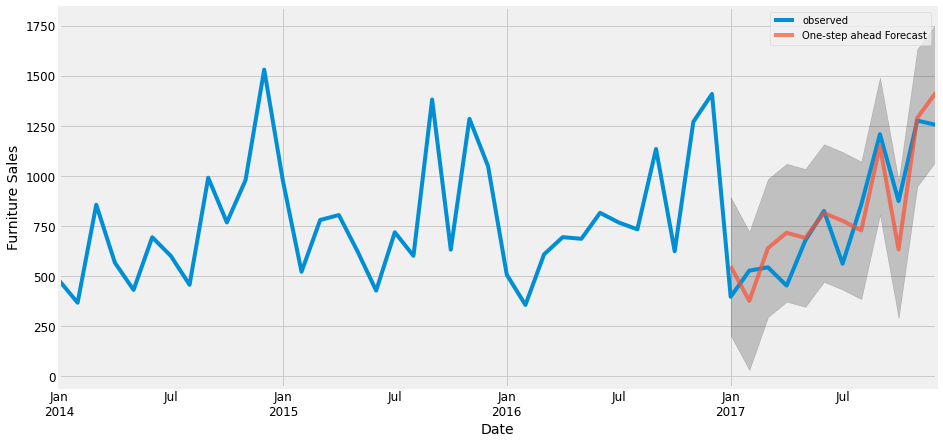

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()

plt.show()

The line plot is showing the observed values compared to the rolling forecast predictions. Overall, our forecasts align with the true values very well, showing an upward trend starts from the beginning of the year.

In [ ]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 22993.57


In [ ]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 151.64


In statistics, the mean squared error (MSE) of an estimator measures the average of the squares of the errors — that is, the average squared difference between the estimated values and what is estimated. The MSE is a measure of the quality of an estimator—it is always non-negative, and the smaller the MSE, the closer we are to finding the line of best fit.

Root Mean Square Error (RMSE) tells us that our model was able to forecast the average daily furniture sales in the test set within 151.64 of the real sales. Our furniture daily sales range from around 400 to over 1200. In my opinion, this is a pretty good model so far.

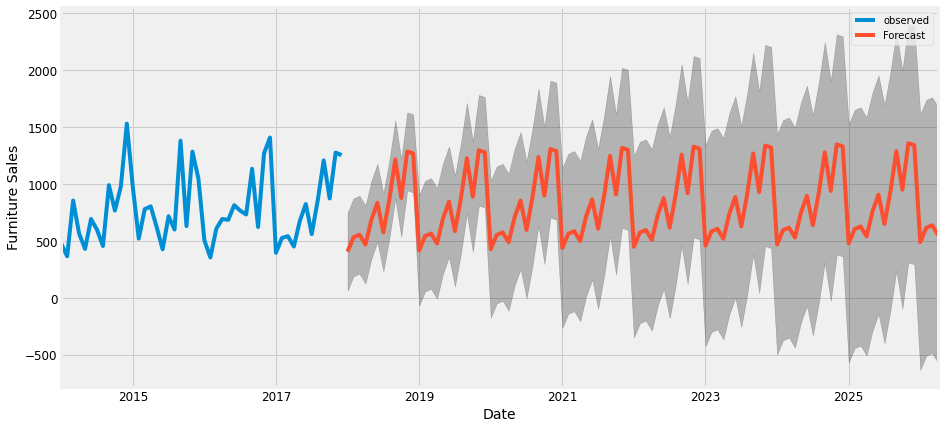

In [ ]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()

ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')

plt.legend()
plt.show()

Our model clearly captured furniture sales seasonality. As we forecast further out into the future, it is natural for us to become less confident in our values. This is reflected by the confidence intervals generated by our model, which grow larger as we move further out into the future.